# <center>DeepIRTools Demo:<br><br>An Identifiable Model for Generating Fake Handwriting</center>
## <center>Author: Christopher J. Urban<br><br>Date: September 18, 2022</center>

The DeepIRTools package includes latent factor models that are capable of representing complex real-world distributions. To demonstrate this capability, I will show how to fit an identifiable latent factor model using the Modified National Institute of Standards and Technology (MNIST; [LeCun, Cortes, and Burges, 1999](#refs)) database of handwritten digits. My approach will use important tools from both <a href="https://en.wikipedia.org/wiki/Deep_learning">deep learning</a> and <a href="https://en.wikipedia.org/wiki/Psychometrics">psychometrics</a>.

## Pre-Processing

Each observation in the MNIST data set is an image $(z_{i,j}) \in \{0, \ldots, 255\}^{28 \times 28}$ of a handwritten digit accompanied by a label $\ell \in \{0, \ldots, 9\}$ indicating which digit the image contains. In words, each image is a $28 \times 28$ grid of pixels taking integer values between 0 and 255. MNIST comes divided into a training set with 60K observations and a test set with 10K observations. I will build my model using the training set.

To preprocess the data, I follow [Salakhutdinov and Murrary (2008)](#refs) in stochastically binarizing each image as follows:
\begin{equation}
    y_{i,j} \sim \text{Bern}(z_{i,j} / 255),
\end{equation}
where $y_{i,j} \in \{0, 1\}$ is a binary pixel, $i=1, \ldots, 28$, $j=1, \ldots, 28$. Each label is represented as a set of $10 - 1 = 9$ dummy variables where $\ell = 0$ is the reference category. A grid with 100 binarized images is shown below.

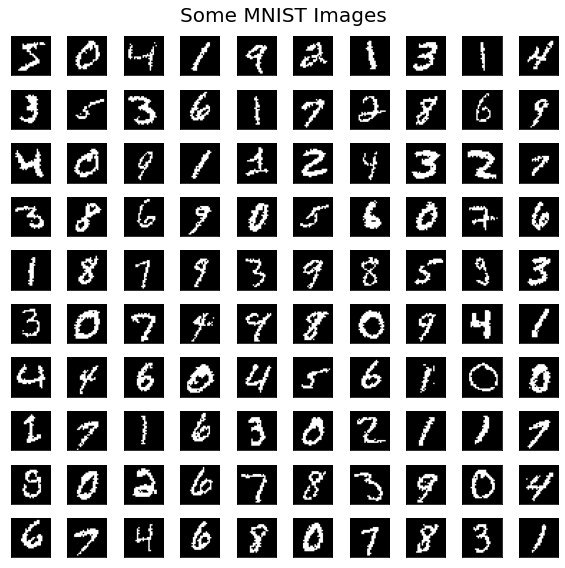

In [1]:
import os
import numpy as np
import torch
import torchvision.datasets as dset
import deepirtools
from deepirtools import IWAVE
from factor_analyzer import Rotator
from matplotlib import pyplot as plt
import seaborn as sns

deepirtools.manual_seed(123) # Seed for reproducibility.

def get_dummies(targets): # Converts a K-category covariate into K-1 dummy variables.
    sample_size = targets.shape[0]
    rng = targets.unique().shape[0]
    dummies = torch.zeros(sample_size, rng)
    dummies[torch.arange(sample_size), targets] = 1
    return dummies[:, 1:]

mnist_train = dset.MNIST(root = "./", train = True, download = True)
data = torch.bernoulli(mnist_train.data.div(255)) # Stochastically binarize images.
labels = get_dummies(mnist_train.targets)

fig, axes = plt.subplots(10, 10, figsize = (8, 8))
fig.suptitle("Some MNIST Images", fontsize = 20)
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i], cmap = "gray")
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

## Latent Factor Models

As mentioned above, I will fit a latent factor model using MNIST. Latent factor models posit that the observed data is generated as follows:
\begin{align} \tag{1}
    \begin{split}
            \mathbf{x} &\sim p(\mathbf{x}) \\
            \mathbf{y} \mid \mathbf{x} &\sim p(\mathbf{y} \mid \mathbf{x}),
    \end{split}
\end{align}
where $\mathbf{x}$ is a $D \times 1$ vector of latent factors and $\mathbf{y}$ is a $J \times 1$ vector of observed variables. The distribution $p(\mathbf{x})$ is called the latent variable prior (deep learning) or the population distribution (psychometrics), while the conditional distribution $p(\mathbf{y} \mid \mathbf{x})$ is called the observation model (deep learning) or the measurement model (psychometrics).

In both deep learning and psychometrics, a common choice for the prior distribution of the latent factors is the standard normal:
\begin{equation}
    p(\mathbf{x}) = \mathcal{N}(\boldsymbol{0}, \boldsymbol{I}_D).
\end{equation}
In psychometrics, the measurement model typically takes the form of a generalized linear model:
\begin{equation*}
    \mathbb{E}[\mathbf{y} \mid \mathbf{x}] = g^{-1}(\mathbf{B}\mathbf{x} + \boldsymbol{\alpha}), \tag{2}
\end{equation*}
where $g: \mathbb{R} \rightarrow \mathbb{R}$ is a link function applied elementwise, $\mathbf{B}$ is a $J \times D$ factor loadings matrix, and $\boldsymbol{\alpha}$ is a $J \times 1$ vector of intercepts. In deep learning, the measurement model is typically more flexible:
\begin{equation*}
    \mathbb{E}[\mathbf{y} \mid \mathbf{x}] = g^{-1}(f_\boldsymbol{\theta}(\mathbf{x})), \tag{3}
\end{equation*}
where $f_\boldsymbol{\theta} : \mathbb{R}^D \rightarrow \mathbb{R}^J$ is an arbitrary continuous map implemented as a neural network parameterized by $\boldsymbol{\theta}$.  (3) is called the nonlinear factor model ([Yalcin and Amemiya, 2001](#refs)) and is typically implemented as a variational autoencoder (VAE; [Kingma and Welling, 2014](#refs); [Rezende, Mohamed, and Wierstra, 2014](#refs)). Clearly $(2)$ is a special case of $(1)$ with $\boldsymbol{\theta} = (\text{vec}(\mathbf{B})^\top, \boldsymbol{\alpha}^\top)^\top$.

## The Problem of Model Non-Identifiability

Since image data are complex, it may initially seem like a flexible neural network-based measurement model is the best choice for MNIST. Unfortunately, the neural network-based model suffers from a major drawback: it is not identifiable ([Khemakhem, Kingma, Pio Monte, and Hyvärinen, 2020](#refs)). Let $\boldsymbol{\omega} \in \Omega$ collect the parameters of $(1)$.<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) Formally, model non-identifiability means that
\begin{equation}
    \forall \boldsymbol{\omega}, \boldsymbol{\omega}' : p_{\boldsymbol{\omega}}(\mathbf{y}) = p_{\boldsymbol{\omega}'}(\mathbf{y}) \;\not\!\!\!\!\implies \boldsymbol{\omega} = \boldsymbol{\omega}'.
\end{equation}
In words, the model is not identifiable if there are two or more distinct values of $\boldsymbol{\omega}$ that produce the same marginal likelihood. Non-identifiability of the nonlinear factor model (3) implies that we may never recover the true joint distribution of $\mathbf{y}$ and $\mathbf{x}$ (up to an equivalence class), even in the limit of infinite data.

Fortunately, it is possible to leverage tools from both psychometrics and deep learning to fit a latent factor model that is both flexible and identifiable. Specifically, I will combine a generalized linear measurement model, a flexible normalizing flow-based latent variable prior, and identification constraints. I discuss these components below.

The measurement model is an item response theory (IRT) model called the multidimensional two-parameter logistic model (M2PL; [McKinley and Reckase, 1983](#refs)):
\begin{equation}
    \text{Pr}(\mathbf{y} = \mathbf{1} \mid \mathbf{x}) = \sigma(\mathbf{B} \mathbf{x} + \boldsymbol{\alpha}),
\end{equation}
where $\sigma(u) = 1 / (1 + \exp[-u])$ is the sigmoid function (deep learning) or inverse logistic link function (psychometrics) applied elementwise. The latent variable prior is a normalizing flow-based density ([Tabak & Turner, 2012](#refs); [Tabak & Vanden-Eijnden, 2010](#refs)):
\begin{equation}
    \mathbf{x} \sim p(\mathbf{x}_0) \prod_{t=1}^T \Big\lvert \det \frac{\partial \mathbf{x}_t}{\partial \mathbf{x}_{t-1}} \Big\rvert^{-1},
\end{equation}
where
\begin{align}
    \begin{split}
    \mathbf{x}_0 &\sim \mathcal{N}(\mathbf{0}, \mathbf{I}_D) \\
    \mathbf{x}_t &= h_{\boldsymbol{\phi}_t}(\mathbf{x}_{t-1}), \; t = 1, \ldots, T,
    \end{split}
\end{align}
with $\mathbf{x} = \mathbf{x}_T$ and $h_{\boldsymbol{\phi}_t} : \mathbb{R}^D \rightarrow \mathbb{R}^D$ a diffeomorphism parameterized by $\boldsymbol{\phi}_t$. In words, normalizing flows are a sequence of invertible maps that transform a simple base density (typically standard normal) into a complicated density. DeepIRTools uses flexible spline coupling transformations ([Durkan, Bekasov, Murray, & Papamakarios, 2019; Doltabadi, Erfani, & Leckie, 2020](#refs)) for the $h_{\boldsymbol{\phi}_t}$ that, when composed together, are universal density approximators ([Teshima et al., 2020](#refs)).

I now impose identification constraints. For a concise review of identification constraints in psychometrics as well as a discussion of associated challenges, see [Millsap, 2001](#refs).

Since $\mathbf{x}$ is latent, we need to establish a metric of measurement by identifying its location and scale. This is straightforward for generalized linear latent factor models like the M2PL: we can identify the location by fixing $D$ elements of $\boldsymbol{\alpha}$ to zero and we may identify the scale by fixing one element in each column of $\mathbf{B}$ to one. Under these constraints, the intercepts $\boldsymbol{\alpha}$ are unique. However, the loadings matrix $\mathbf{B}$ and the parameters of the normalizing flow $h_{\boldsymbol{\phi}_T} \circ \ldots \circ h_{\boldsymbol{\phi}_0}$ (in function space) are only identified up to a rotation:
\begin{align}
    \text{Pr}(\mathbf{y} = \mathbf{1} \mid \mathbf{x}) &= \sigma(\mathbf{B} \mathbf{x} + \boldsymbol{\alpha}) \\
    &= \sigma(\tilde{\mathbf{B}} \tilde{\mathbf{x}} + \boldsymbol{\alpha}),
\end{align}
where $\tilde{\mathbf{B}} = \mathbf{B} \mathbf{R}$, $\tilde{\mathbf{x}} = \mathbf{R}^\top \mathbf{x}$, and $\mathbf{R}$ is a $D \times D$ orthogonal matrix. Following psychometric tradition, I will choose a $\mathbf{B}^*$ from the equivalence class *post hoc* by optimizing a rotation criterion function $\mathcal{Q}(\mathbf{R}; \mathbf{B})$ w.r.t. $\mathbf{R}$. $\mathcal{Q}(\mathbf{R}; \mathbf{B})$ is designed to increase interpretability by ensuring that most loadings are small. Specifically, I will choose $\mathbf{B}^*$ by optimizing the Geomin rotation criterion ([Yates, 1988](#refs)):
\begin{equation}
    \mathcal{Q}(\mathbf{R}; \mathbf{B}) = \sum_{j = 1}^J \bigg[ \prod_{d = 1}^D \big( \tilde{b}_{j, d}^2 + \epsilon \big) \Bigg],
\end{equation}
where $\tilde{b}_{j, d}$ is an element of $\tilde{\mathbf{B}}$ and $\epsilon > 0$ is small. 

<a name="cite_note-1"></a>1. [^](#cite_ref-1) $\boldsymbol{\omega}$ includes the parameters of the neural network in function space rather than the learned parameters $\boldsymbol{\theta}$ ([Section 2.2, Khemakhem, Kingma, Pio Monte, and Hyvärinen, 2020](#refs)).

## Conditional Generative Models

Sampling from a fitted latent factor model generates a random sample of realistic fake observations. In many image modeling applications, however, the goal is to generate realistic fake images while exerting some degree of control over the *kinds* of images generated. With MNIST, for example, we may wish to choose which digits to generate from our fitted model. This can be accomplished by conditioning the model on covariates as follows:
\begin{align}
    \mathbf{x} \mid \mathbf{c} &\sim p(\mathbf{x} \mid \mathbf{c}) \\
    \mathbf{y} \mid \mathbf{x}, \mathbf{c} &\sim p(\mathbf{y} \mid \mathbf{x}, \mathbf{c}),
\end{align}
where $\mathbf{c}$ is a $C \times 1$ vector of covariates. Conditional latent factor models are typically implemented as conditional VAEs ([Sohn, Yan, and Lee, 2015](#refs)) in deep learning and as latent regression models ([Camilli and Fox, 2015](#refs); [von Davier and Sinharay, 2010](#refs)) in psychometrics.

## Analysis

I now implement the model described above with $D = 32$ latent factors. Each image is flattened into a vector with $J = 784$ elements. I implement the identification constraints via linear constraints encoded in a $JD \times JD$ matrix $\mathbf{A}$ and a $JD \times 1$ vector $\mathbf{b}$ (for details, see <a href="https://deepirtools.readthedocs.io/en/latest/">deepirtools.readthedocs.io</a>). The anchor items – that is, the observed variables that each have one intercept fixed to zero and one loading fixed to one to identify the location and scale of the latent factors, respectively – are the $D = 32$ items with the highest sample variance.

I fit the model below using a GPU (total runtime around three hours). DeepIRTools returns an importance-weighted amortized variational estimator (I-WAVE) for the model parameters; for details, see [Urban and Bauers, 2021](#refs).

In [2]:
sample_size = data.shape[0]
Y = data.view(sample_size, -1)
n_items = Y.shape[1]
latent_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ref_idxs = Y.var(dim = 0).sort(descending = True)[1][:latent_size] # Find anchor items.
A = torch.ones(latent_size * n_items)
b = torch.zeros(latent_size * n_items)
for factor_idx in range(latent_size):
    ref_idx = ref_idxs[factor_idx]
    A[n_items * factor_idx + ref_idx] = 0
    b[n_items * factor_idx + ref_idx] = 1 # Fix anchor item's loading on one factor to one.
A = A.diag()
ints_mask = torch.ones(n_items); ints_mask[ref_idxs] = 0 # Fix anchor item intercepts to zero.

load_model = os.path.exists("./models/conditional_mnist.pth")

model = IWAVE(model_type = "grm", # "grm" = graded response model for ordinal observed variables.
                                  # When each variable has 2 categories, reduces to the M2PL.
              learning_rate = 5e-4 if device=="cpu" else 1e-3, # Bigger learning rate with increased
                                                               # batch size on GPU.
              device = device,
              A = A,
              b = b,
              ints_mask = ints_mask,
              inference_net_sizes = [256], # Inference neural network hidden layer sizes.
              latent_size = latent_size,
              n_cats = [2] * n_items, # Number of categories for each observed variable.
              fixed_variances = False, # Fixes factor variances to one when multivariate normal
                                       # latent variable prior used; N/A to flows.
              fixed_means = False, # Fixes multivariate normal prior mean to zero; N/A to flows.
              covariate_size = labels.shape[1], # Number of dummies representing label.
              use_spline_prior = True,
              count_bins = 32, # Increasing count_bins increases flexibility of latent variable prior.
              spline_net_sizes = [128], # Hidden layer sizes for neural net mapping from label to
                                        # mean of flow base density.
              spline_init_normal = not load_model, # Initialize flow density close to standard normal
                                                   # by optimizing with standard normal samples.
              log_interval = 25,
             )
if load_model:
    model.load_model("conditional_mnist", "./models")
else:
    model.fit(Y, batch_size = 128 if device=="cpu" else 1024, covariates = labels) # Bigger batches on GPU.
    os.makedirs("./models", exist_ok = True)
    model.save_model("conditional_mnist", "./models")


Initializing model parameters
Initialization ended in  0.03  seconds


I first show ten samples from the fitted model for each label $\ell = 0, \ldots, 9$. The samples are stylistically diverse are mostly pretty convincing, suggesting the model has done a decent job of capturing the marginal distribution of the observed data. I note that the model was fitted with non-specialized neural network architectures; specialized architectures for modeling images (e.g., convolutional neural networks) would very likely enhance sample realism.

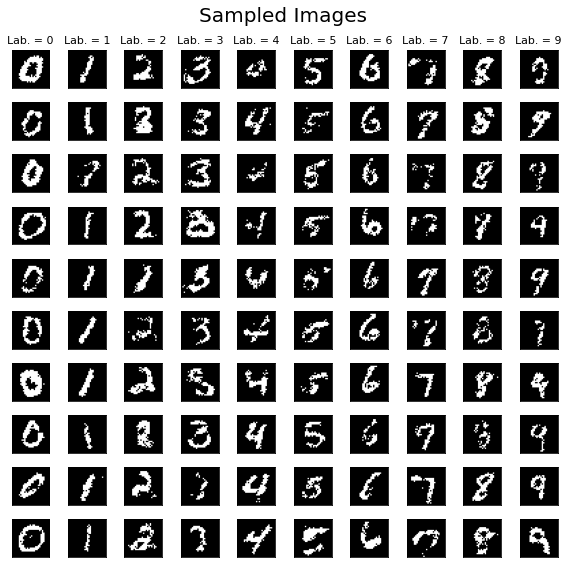

In [3]:
sampled_labels = get_dummies(torch.cat([torch.arange(10)] * 10, dim = 0))
obs = model.sample(sample_size = 100, covariates = sampled_labels)["obs"]

fig, axes = plt.subplots(10, 10, figsize = (8, 8))
fig.suptitle("Sampled Images", fontsize = 20)
for i, ax in enumerate(axes.flat):
    ax.imshow(obs[i].reshape(-1, 28, 28)[0], cmap = "gray")
    if i < 10:
        ax.set_title("Lab. = {:d}".format(i), fontsize = 11)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

To evaluate my model's ability to generalize to new data, I calculate the mean approximate negative log-likelihood of the MNIST test (i.e., holdout) set using 5000 importance-weighted samples. The value of $89.47$ is competitive with typical VAE baselines (i.e., models with neural network-based measurement models) using binarized MNIST (e.g., [Feng, Wang, and Liu, 2017](#refs)), though of course typical baselines are unconditional models. This result is in line with the finding in psychometrics that equivalent fits to data may be obtained using either a flexible measurement model or a flexible latent prior ([Woods and Thissen, 2006](#refs)). As noted above, more specialized neural network architectures could likely be leveraged to bring this value closer to state-of-the-art.

In [4]:
mnist_test = dset.MNIST(root = "./", train = False, download = True)
test_size = mnist_test.data.shape[0]
Y_test = torch.bernoulli(mnist_test.data.div(255)).view(test_size, -1)
labels_test = get_dummies(mnist_test.targets)
ll = model.log_likelihood(data = Y_test, covariates = labels_test, iw_samples = 5000) # Increasing iw_samples
                                                                                      # improves the approximation to
                                                                                      # the true LL.
print("Mean training set log-likelihood: {:.2f}".format(-ll / test_size))


Computing approx. LL
Approx. LL computed in 4112.95 seconds
Mean training set log-likelihood: 89.47


I now apply Geomin rotation to obtain the rotated loadings matrix $\mathbf{B}^*$. The loadings heatmap below shows repeating bands of high and/or low loadings that differ for each latent factor (i.e., column). Unfortunately, interpreting the loadings in this format is challenging. I will reformat the loadings to improve interpretability below.

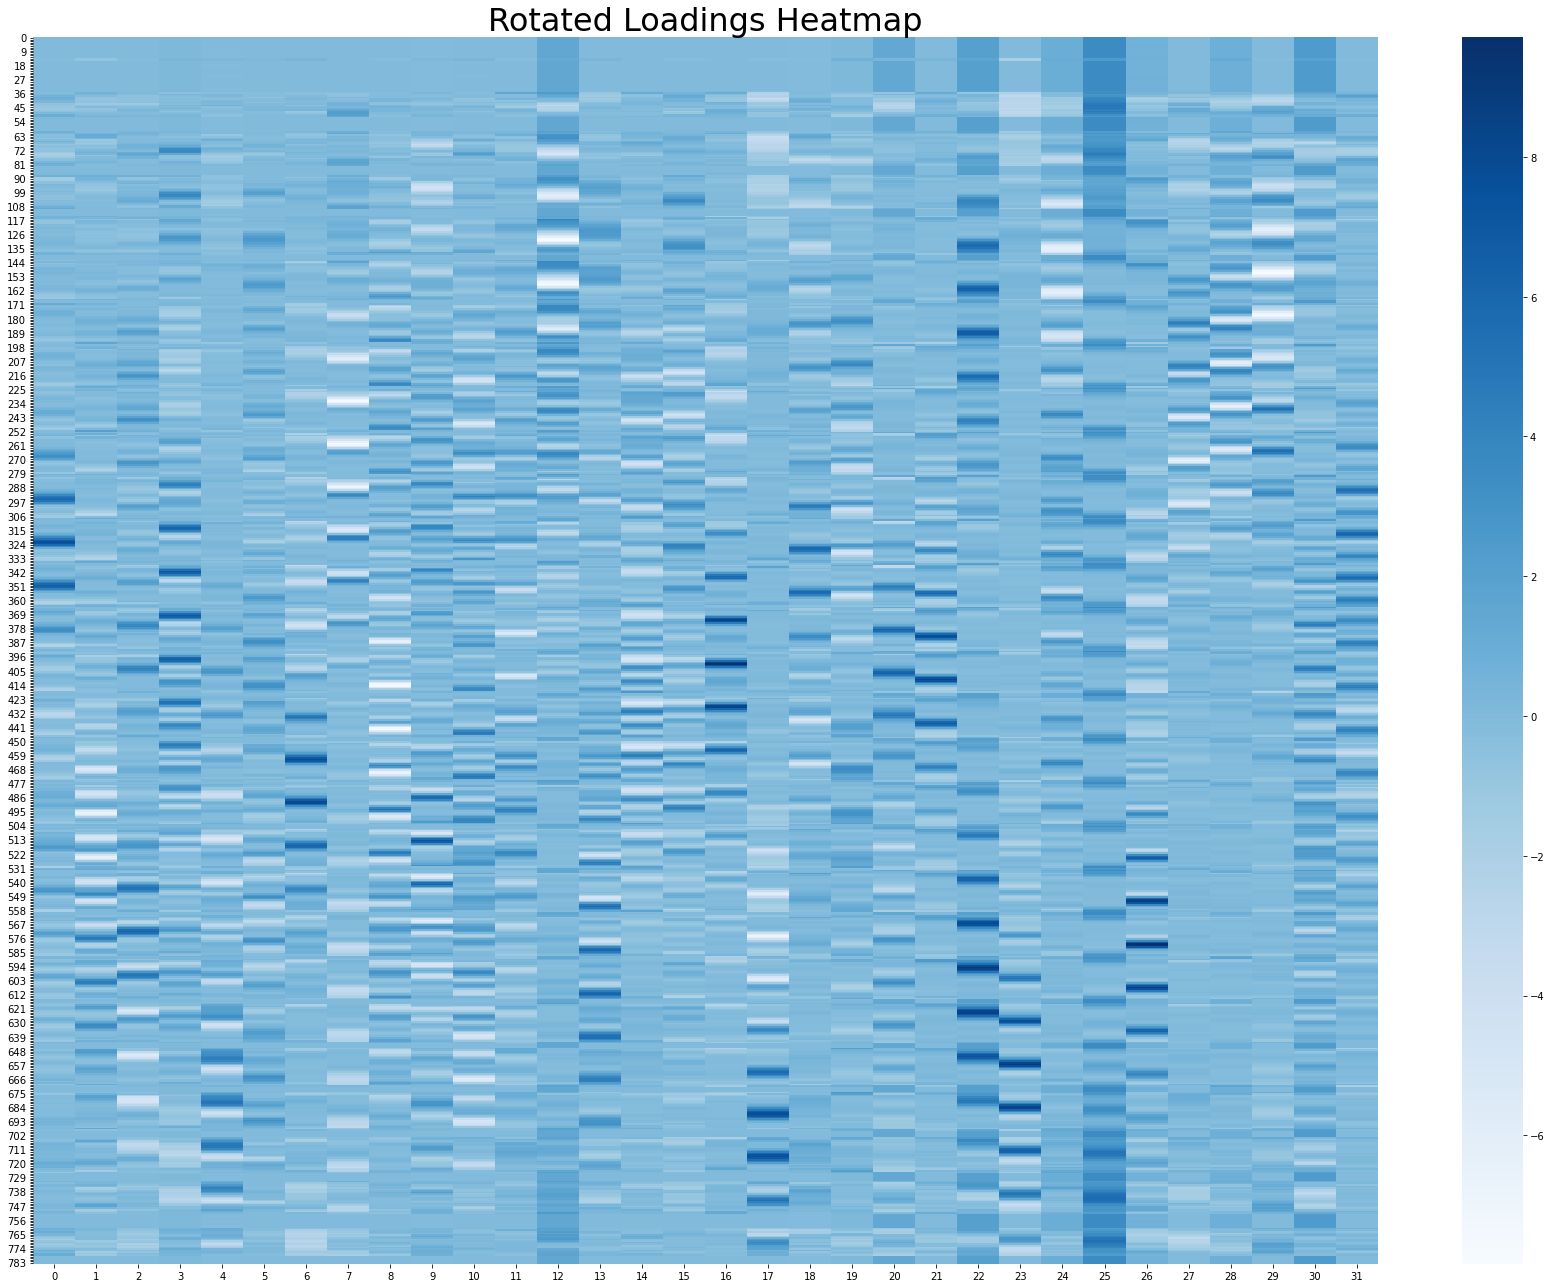

In [5]:
rotator = Rotator(method = "geomin_obl")
rot_loadings = torch.from_numpy(rotator.fit_transform(model.loadings))

fig, ax = plt.subplots(figsize = (24, 18))
hm = sns.heatmap(rot_loadings, cbar = True, fmt = ".2f", cmap = plt.cm.Blues)
ax.set_xticks(np.arange(rot_loadings.shape[1]) + 0.5)
ax.set_yticks(np.arange(rot_loadings.shape[0]) + 0.5)

ax.set_title("Rotated Loadings Heatmap", fontsize = 32)
plt.tight_layout()
fig.savefig("rotated_loadings.pdf")

Here is where things get interesting. Column $d$ of $\mathbf{B}^*$ tells us the strength and direction of the linear association between latent factor $d$ and each MNIST pixel. If I reshape each column into the shape of an MNIST image, I can visually inspect which parts of the image each latent factor influences as well as the direction of influence. In other words, the rotated loadings are a tool for *interpreting* the latent factors (just like in psychometrics). Even cooler, given that the model is not misspecified and optimization succeeded, I can recover the *true* latent factors that generated the data!

I plot reshaped loadings vectors below. Dark blue (resp., white) regions indicate that higher values of the latent factor tend to produce white pixels (resp., black). I see a number of different kinds of factors:

- Higher values of factor 25 increase the probability of seeing white pixels around the edge of the image.
- Higher values of factors 0, 6, 16, 17, 21, 22, 23, and 26 produce large clusters of white pixels, while higher values of factors 7, 24, 28, and 29 produce large clusters of black pixels.
- Factors 2, 3, 5, 8–10, 13–15, and 30 produce complex shapes in the center of the image.

This method of interpreting the factors fits with the notion that visual data often requires visual explanations ([Rudin et al., 2021](#refs)).

/var/folders/w5/lkcb5z4n455_x8bp581kwpdc0000gn/T/ipykernel_35845/2267986892.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])


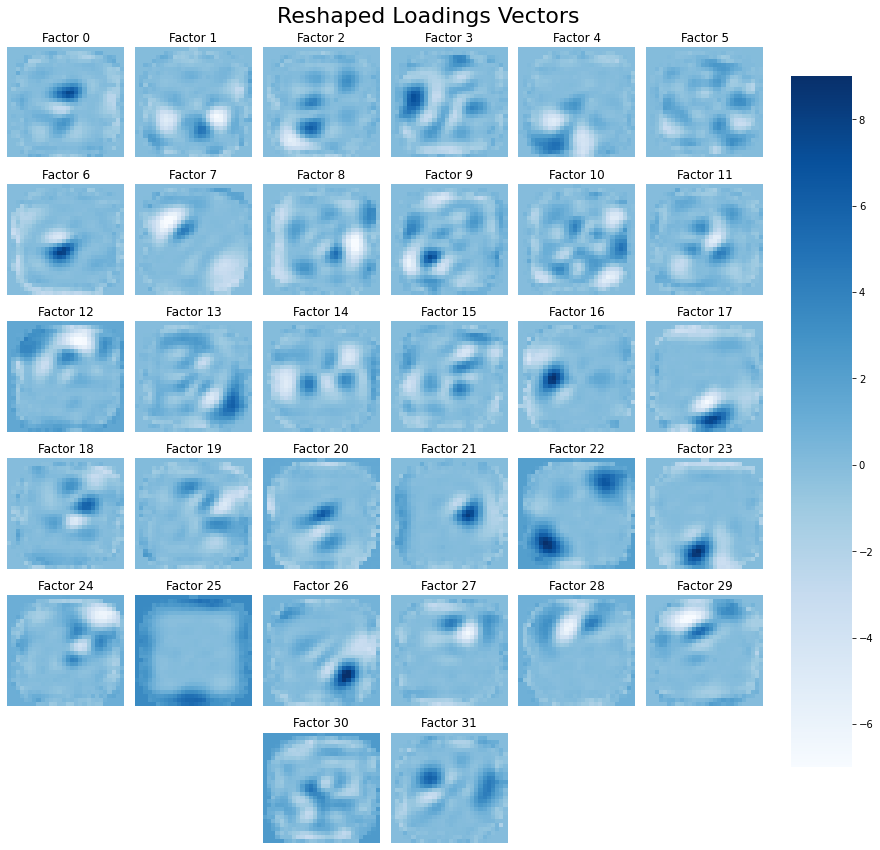

In [6]:
fig, axes = plt.subplots(6, 6, figsize = (12, 12))
fig.suptitle("Reshaped Loadings Vectors", fontsize = 22)
cbar_ax = fig.add_axes([0.92, 0.1, 0.07, 0.8])
for i, ax in enumerate(axes.flat):
    if i < 30:
        sns.heatmap(rot_loadings[:, i].reshape(-1, 28, 28)[0], ax = ax,
                    vmax = 9, vmin = -7, cbar = i == 0, fmt = '.2f',
                    cmap = plt.cm.Blues, cbar_ax = None if i else cbar_ax)
        ax.set_title("Factor " + str(i))
    elif 31 < i < 34:
        sns.heatmap(rot_loadings[:, i - 2].reshape(-1, 28, 28)[0], ax = ax,
            vmax = 9, vmin = -7, cbar = i == 0, fmt = '.2f',
            cmap = plt.cm.Blues, cbar_ax = None if i else cbar_ax)
        ax.set_title("Factor " + str(i - 2))
    else:
        ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout(rect=[0, 0, 0.9, 1])

fig.savefig("reshaped_loadings_vectors.pdf")

## References <a id='refs'></a>

- Camilli, G., & Fox, J.-P. (2015). An aggregate IRT procedure for exploratory factor analysis. *Journal of Educational and Behavioral Statistics*, *40*, 377–401.

- Dolatabadi, H. M., Erfani, S., & Leckie, C. (2020). Invertible generative modeling using linear rational splines. *Proceedings of the 23<sup>rd</sup> International Conference on Artificial Intelligence and Statistics*, *108*, 4236–4246.

- Durkan, C., Bekasov, A., Murray, I., & Papamakarios, G. (2019). Neural spline flows. *Advances in Neural Information Processing Systems*, *32*.

- Feng, Y., Wang, D., & Liu, Q. (2017). Learning to draw samples with amortized Stein variational gradient descent. In *Proceedings of the 33<sup>rd</sup> Conference on Uncertainty in Artificial Intelligence*.

- Khemakhem, I., Kingma, D. P., Pio Monte, R., and Hyvärinen, A. (2020). Variational autoencoders and nonlinear ICA:
A unifying framework. In *Proceedings of the 23<sup>rd</sup> International Conference on Artificial
Intelligence and Statistics*, *108*.

- Kingma, D. P., & Welling, M. (2014). Auto-encoding variational Bayes. In *2<sup>nd</sup> International Conference on Learning
Representations*. ICLR.

- LeCun, Y., Cortes, C., & Burges, C. J. C. (1999). The MNIST database of handwritten digits. Retrieved from http://yann.lecun.com/exdb/mnist/

- McKinley, R., & Reckase, M. (1983). An extension of the two-parameter logistic model to the multidimensional latent
space (Research Report ONR83-2). The American College Testing Program.

- Millsap, R. E. (2001) When trivial constraints are not trivial: The choice of uniqueness constraints in confirmatory factor analysis. *Structural Equation Modeling*, *8*(1), 1–17

- Rezende, D. J., Mohamed, S., & Wierstra, D. (2014). Stochastic backpropagation and approximate inference in deep
generative models. In *Proceedings of the 31<sup>st</sup> International Conference on Machine Learning* (pp. 1278–1286).

- Rudin, C., Chen, C., Chen, Z., Huang, H., Semenova, L., & Zhong, C. (2021). Interpretable machine learning: Fundamental principles and 10 grand challenges. *Statistics Surveys*, *16*, 1–85.

- Salakhutdinov, R., & Murray, I. (2008). On the quantitative analysis of deep belief networks. In *Proceedings of the 25<sup>th</sup> International Conference on Machine Learning*.

- Sohn, K., Yan, X., & Lee, H. (2015). Learning structured output representation using deep conditional generative models. *Advances in Neural Information Processing Systems*, *28*.

- Tabak, E. G., & Turner, C. V. (2012). A family of nonparametric density estimation algorithms. *Communications on Pure and Applied Mathematics*, *66*(2), 145–164.

- Tabak, E. G., & Vanden-Eijnden, E. (2010). Density estimation by dual ascent of the log-likelihood. *Communications in Mathematical Sciences*, *8*(1), 217–233.

- Teshima, T., Ishikawa, I., Tojo, K., Oono, K., Ikeda, M., & Sugiyama, M. (2020). Coupling-based invertible neural networks are universal diffeomorphism approximators. *Advances in Neural Information Processing Systems*, *33*.

- Urban, C. J., & Bauer, D. J. (2021). A deep learning algorithm for high-dimensional exploratory item factor analysis. *Psychometrika*, *86(*1), 1–29.

- von Davier, M., & Sinharay, S. (2010). Stochastic approximation methods for latent regression item response models. *Journal of Educational and Behavioral Statistics*, *35*(2), 174–193.

- Woods, C. M., & Thissen, D. (2006). Item response theory with estimation of the latent population distribution using spline-based densities. *Psychometrika*, *71*(2), 281–301.

- Yalcin, I., & Amemiya, Y. (2001). Nonlinear factor analysis as a statistical method. *Statistical Science*, *16*(3), 275–294.

- Yates, A. (1988). *Multivariate Exploratory Data Analysis: A Perspective on Exploratory Factor Analysis*. Albany: State University of New York Press.